# Problem Set 1

## Exercise 1

In this exercise, I will treat the owner's problem with a discrete choice model.

$$V(p,B) = \max \{V^{1}(p,B),V^{0}(p,B))\} $$

where

$$V^{1}(p,B) =pB$$

and

$$V^{0}(p,B) =\frac{1}{1+r} V(p',B)$$

Note that $V^{1}(p,B)$ is the value function for selling the barrels, whereas $V^{0}(p,B)$ is the value function for holding the barrels when the price and the number of barrels are $(p,B)$ respectively. 

### 1. What are the state variables?
Answer : $(p,B)$  is the state vector for this problem.
### 2. What are the control variables? 
Answer : $\{\text{sell, not sell}\}$ $\rightarrow$ binary choice $\{1,0\}$. Hence, $z \in \{1,0\}$.
### 3. What does the transition equation look like?
Answer : $B′ = B$ if $z = 0$ (the decision of not selling), $B′ = 0$ if $z = 1$ (decision of selling)
### 4. Write down the sequence problem of the owner. Write down the Bellman equation.
Answer : Since the problem is a discrete choice, it is not possible to map the problem to the sequence problem. The Bellman form is as above.
### 5. What does the owner's Euler equation look like? 
Answer : In this setting, there is no Euler equation because the problem is not continuous.
### 6. 
Answer : Suppose the price is $p_t = p_{t+1}$ for all $t$ and suppose $r > 0$ in this problem. Then, the policy function is $\Phi(p,B) = 1$ for all across the state variables, which implies he sells the barrels.

Suppose $r < 0$ in this problem. Then, the policy function is $\Phi(p,B) = 0$ for all across the state variables, which implies he will not sell the barrels(because the present value of the oil barrels keeps growing).

Suppose the price is $\frac{p_t}{(1+r)^t} < \frac{p_{t+1}}{(1+r)^{t+1}}$ for all $t$ .Then, the policy function is $\Phi(p,B) = 0$ for all across the state variables, which implies he will not sell the barrels(because the present value of the oil barrels keeps growing).

When the price is $\frac{p_t}{(1+r)^t} = \frac{p_{t+1}}{(1+r)^{t+1}}$ for all $t$, then this condition produce interior solutions. 

## Exercise 2

### 1. What are the state variables?
Answer : $(k_t,z_t)$
### 2. What are the control variables?
Answer : $(k_{t+1}, c_t, i_t)$
### 3. Write down the Bellman Equation that represents this sequence problem.
Answer :
\begin{align*}
V(k_{t}) = & \max_{c_{t} \in [0,z_{t}k_{t}^{\alpha}]}  u(c_{t}) + \beta \mathbb{E}_{t} [V(k_{t+1})]  \\  & \text{s.t.} \quad  c_{t} + k_{t+1} = z_{t}k_{t}^{\alpha} + (1-\delta) k_{t} \\  & \quad \quad \quad k_{t} \geq 0 \quad \text{for all t}\geq 0 \\ & \quad \quad \quad ln(z_{t}) \sim N(0, \sigma_{z})
\end{align*}

where $ \mathbb{E}_{t} = \int z_{t} \phi (z_{t})dt$ and $\phi(.)$ is pdf of normal distribution. 

In [120]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt

# to print plots inline
%matplotlib inline

# Declare parameters
# Preference parameters
beta = 0.96
gamma = 0.5          #Risk Aversion Coefficient

# Production shock z_t parameters: AR(1) process: ln(z_{t+1}) = rho * ln(z_{t}) + v_t
# v_t ~ N(0, sigma_v)
sigma_z = 0.2
mu_z = 0
size_z = 4  # number of grid points in epsilon-space
rho = 0
sigma_v = sigma_z * np.sqrt(1 - rho)
alpha = 0.4

# Depreciation Rate
delta = .05

# Capital growth rate
R = 1 - delta

In [121]:
# Create Grid Space
lb_k = 5
ub_k = 15
size_k = 200  # Number of grid points
k_grid_rev = np.empty(size_k)
for t in range(size_k):
    k_grid_rev[t] = (R ** t) * ub_k # note how construct so don't have to interpolate
k_grid = k_grid_rev[::-1]            # order smallest to largest
#k_grid = np.linspace(lb_k, ub_k, size_k)

In [122]:
#Create grid of shocks

from scipy.stats import norm
import scipy.integrate as integrate

def integrand(x, sigma_z, sigma, rho, mu, z_j, z_jp1):
    """
    Integrand in the determination of transition probabilities from the Adda-
    Cooper method.
    """
    val = (np.exp((-1 * ((x - mu) ** 2)) / (2 * (sigma_z ** 2)))
           * (norm.cdf((z_jp1 - (mu * (1 - rho)) - (rho * x)) / sigma)
               - norm.cdf((z_j - (mu * (1 - rho)) - (rho * x)) / sigma)))

    return val

def addacooper(N, mu, rho, sigma):
    # Compute std dev of the stationary distribution of z
    sigma_z = sigma / ((1 - rho ** 2) ** (1 / 2))

    # Compute cut-off values
    z_cutoffs = (sigma_z * norm.ppf(np.arange(N + 1) / N)) + mu

    # compute grid points for z
    z_grid = ((N * sigma_z * (norm.pdf((z_cutoffs[:-1] - mu) / sigma_z)
                              - norm.pdf((z_cutoffs[1:] - mu) / sigma_z)))
              + mu)

    # compute transition probabilities
    pi = np.empty((N, N))
    for i in range(N):
        for j in range(N):
            results = integrate.quad(integrand, z_cutoffs[i], z_cutoffs[i + 1],
                                     args=(sigma_z, sigma, rho, mu,
                                           z_cutoffs[j], z_cutoffs[j + 1]))
            pi[i, j] = (N / np.sqrt(2 * np.pi * sigma_z ** 2)) * results[0]

    return z_grid, pi

#z_grid, pi_t = addacooper(size_z, mu_z, rho, sigma_v)
ln_z_grid, pi_t = addacooper(size_z, mu_z, rho, sigma_v)
z_grid = np.exp(ln_z_grid)
pi = np.transpose(pi_t)
z_grid


array([0.77552019, 0.93713066, 1.06708706, 1.28945708])

In [123]:
# Value Function Iteration
VFtol = 1e-3 
VFdist = 7.0 
VFmaxiter = 3000 
V = np.zeros((size_k, size_z)) # initial guess at value function
Vmat = np.zeros((size_k, size_k, size_z)) # initialize Vmat matrix
PF = np.zeros((size_k, size_z)) # Policy function index
VFiter = 0
 

while VFdist > VFtol and VFiter < VFmaxiter:
    for i in range(size_k): # loop over captital
        for j in range(size_z): # loop over shock
            for ii in range(size_k): # loop over capital'
                EV=0
                for jj in range(size_z): #loop over shock'
                    EV += pi[j, jj] * V[ii, jj]
                 
                c=np.exp(z_grid[j])*(k_grid[i]**alpha) - k_grid[ii]+(1-delta)*k_grid[i] 
                if c < 0:
                    c = 1e-5
                Vmat[i, ii, j]  = (c**(1-gamma))/(1-gamma) + beta * EV 
       
    
            TV = Vmat.max(1) # apply max operator to Vmat (to get V(w))
            PF = np.argmax(Vmat, axis=1)
    
    VFdist = (np.absolute(V - TV)).max()  # check distance
    V = np.copy(TV)
    VFiter += 1
    print(VFiter,VFdist)
    
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')            

VF = V # solution to the functional equation    

1 9.995101956149233
2 8.46400057695424
3 5.182153713130649
4 4.974867564605455
5 4.535204468398192
6 4.316816745230781
7 4.140009003428837
8 3.974408643291703
9 3.815432297560065
10 3.6628150056576843
11 3.5163024054314036
12 3.3756503092141585
13 3.24062429684561
14 3.1109993249718073
15 2.9865593519729714
16 2.8670969778940503
17 2.7524130987783053
18 2.6423165748271913
19 2.5366239118341127
20 2.4351589553607766
21 2.3377525971463626
22 2.244242493260515
23 2.1544727935301182
24 2.068293881788918
25 1.9855621265173795
26 1.90613964145669
27 1.8298940557984338
28 1.7566982935665152
29 1.6864303618238665
30 1.6189731473509
31 1.5542142214569026
32 1.4920456525986197
33 1.4323638264946794
34 1.375069273434903
35 1.320066502497525
36 1.2672638423976252
37 1.2165732887017242
38 1.1679103571536729
39 1.1211939428675493
40 1.076346185152829
41 1.0332923377467154
42 0.9919606442368831
43 0.9522822184673885
44 0.9141909297287043
45 0.8776232925395675
46 0.8425183608379996
47 0.80881762640447

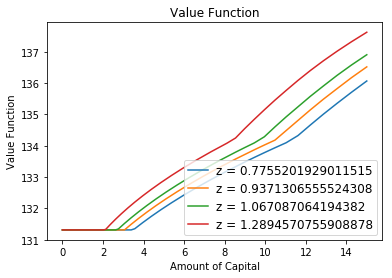

In [124]:
# Plot value function 
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[1:], VF[1:,0], label= 'z = ' + str(z_grid[0]))
ax.plot(k_grid[1:], VF[1:,1], label= 'z = ' + str(z_grid[1]))
ax.plot(k_grid[1:], VF[1:,2], label= 'z = ' + str(z_grid[2]))
ax.plot(k_grid[1:], VF[1:,3], label= 'z = ' + str(z_grid[3]))
# Now add the legend with some customizations.
legend = ax.legend(loc='lower right', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Amount of Capital')
plt.ylabel('Value Function')
plt.title('Value Function')
plt.show()

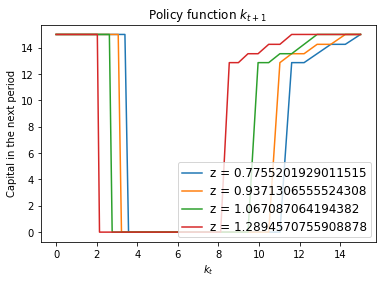

In [125]:
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[1:],  k_grid[PF[1:,0]], label= 'z = ' + str(z_grid[0]))
ax.plot(k_grid[1:],  k_grid[PF[1:,1]], label= 'z = ' + str(z_grid[1]))
ax.plot(k_grid[1:],  k_grid[PF[1:,2]], label= 'z = ' + str(z_grid[2]))
ax.plot(k_grid[1:],  k_grid[PF[1:,3]], label= 'z = ' + str(z_grid[3]))

# Now add the legend with some customizations.
legend = ax.legend(loc='lower right', shadow=False)

# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

plt.xlabel('$k_t$')
plt.ylabel('Capital in the next period')
plt.title('Policy function $k_{t+1}$ ')
plt.show()

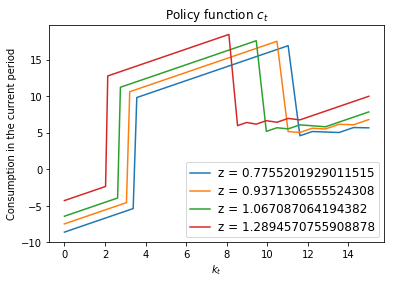

In [126]:
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[1:],  np.exp(z_grid[0])*(k_grid[i]**alpha) - k_grid[PF[1:,0]]+(1-delta)*k_grid[1:], label= 'z = ' + str(z_grid[0]))
ax.plot(k_grid[1:],  np.exp(z_grid[1])*(k_grid[i]**alpha) - k_grid[PF[1:,1]]+(1-delta)*k_grid[1:], label= 'z = ' + str(z_grid[1]))
ax.plot(k_grid[1:],  np.exp(z_grid[2])*(k_grid[i]**alpha) - k_grid[PF[1:,2]]+(1-delta)*k_grid[1:], label= 'z = ' + str(z_grid[2]))
ax.plot(k_grid[1:],  np.exp(z_grid[3])*(k_grid[i]**alpha) - k_grid[PF[1:,3]]+(1-delta)*k_grid[1:], label= 'z = ' + str(z_grid[3]))

# Now add the legend with some customizations.
legend = ax.legend(loc='lower right', shadow=False)

# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

plt.xlabel('$k_t$')
plt.ylabel('Consumption in the current period')
plt.title('Policy function $c_{t}$ ')
plt.show()

## Exercise 3

### 1.
\begin{align*}
V(k_{t}) = & \max_{c_{t} \in [0,z_{t}k_{t}^{\alpha}]}  u(c_{t}) + \beta \mathbb{E}_{t} [V(k_{t+1})|z_{t}]   \\  & \text{s.t.} \quad  c_{t} + k_{t+1} = z_{t}k_{t}^{\alpha} + (1-\delta) k_{t} \\  & \quad \quad \quad k_{t} \geq 0 \quad \text{for all t}\geq 0 \\ & \quad \quad \quad ln(z_{t}) = \rho ln(z_{t-1}) + \upsilon_{t}
 \end{align*}

In [127]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt

# to print plots inline
%matplotlib inline

# Set parameters for Neo-Classical Models
size_z = 4
beta = 0.96
delta = 0.05
alpha = 0.4
gamma = 0.5

# Create Grid Space
lb_k = 5
ub_k = 15
size_k = 200  # Number of grid points
k_grid_rev = np.empty(size_k)
for t in range(size_k):
    k_grid_rev[t] = (R ** t) * ub_k # note how construct so don't have to interpolate
k_grid = k_grid_rev[::-1]            # order smallest to largest
#k_grid = np.linspace(lb_k, ub_k, size_k)

# Approximate markov chain for log(z)
mu1 = 0.0
rho1  = 0.8
sigma_v = 0.1
#z_grid, pi_t = addacooper(size_z, mu_z, rho, sigma_v)
ln_z_grid, pi_t = addacooper(size_z, mu_z, rho, sigma_v)
z_grid = np.exp(ln_z_grid)
pi = np.transpose(pi_t)
z_grid 

array([0.88063624, 0.96805509, 1.03299906, 1.13554263])

In [128]:
# Value Function Iteration
VFtol = 1e-3 
VFdist = 7.0 
VFmaxiter = 3000 
V = np.zeros((size_k, size_z)) # initial guess at value function
Vmat = np.zeros((size_k, size_k, size_z)) # initialize Vmat matrix
PF = np.zeros((size_k, size_z)) # Policy function index
VFiter = 0
 

while VFdist > VFtol and VFiter < VFmaxiter:
    for i in range(size_k): # loop over captital
        for j in range(size_z): # loop over shock
            for ii in range(size_k): # loop over capital'
                EV=0
                for jj in range(size_z): #loop over shock'
                    EV += pi[j, jj] * V[ii, jj]
                 
                c=np.exp(z_grid[j])*(k_grid[i]**alpha) - k_grid[ii]+(1-delta)*k_grid[i] 
                if c < 0:
                    c = 1e-5
                Vmat[i, ii, j]  = (c**(1-gamma))/(1-gamma) + beta * EV 
       
    
            TV = Vmat.max(1) # apply max operator to Vmat (to get V(w))
            PF = np.argmax(Vmat, axis=1)
    
    VFdist = (np.absolute(V - TV)).max()  # check distance
    V = np.copy(TV)
    VFiter += 1
    print(VFiter,VFdist)
    
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')            

VF = V # solution to the functional equation 

1 9.684088466733236
2 8.388729208652913
3 5.130287623889421
4 4.925076118933845
5 4.479433801485271
6 4.265959602609108
7 4.095184934195927
8 3.931377536828087
9 3.7741224353549683
10 3.62315753794077
11 3.4782312364231416
12 3.339101986966213
13 3.2055379074875674
14 3.077316391188056
15 2.9542237355405305
16 2.8360547861189076
17 2.7226125946741604
18 2.613708090887201
19 2.5091597672517167
20 2.4087933765616327
21 2.3124416414991913
22 2.2199439758392003
23 2.1311462168056323
24 2.0459003681334167
25 1.9640643534080766
26 1.8855017792717632
27 1.8100817081008813
28 1.7376784397768574
29 1.668171302185769
30 1.6014444500983416
31 1.5373866720944136
32 1.4758912052106439
33 1.4168555570022079
34 1.3601813347221139
35 1.3057740813332401
36 1.253543118079918
37 1.203401393356728
38 1.1552653376224384
39 1.1090547241175415
40 1.0646925351528296
41 1.022104833746738
42 0.981220640396856
43 0.9419718147809704
44 0.9042929421897412
45 0.8681212245021612
46 0.833396375522085
47 0.80006052050

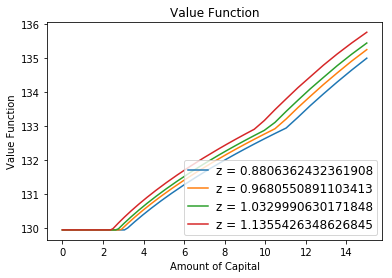

In [129]:
# Plot value function 
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[1:], VF[1:,0], label= 'z = ' + str(z_grid[0]))
ax.plot(k_grid[1:], VF[1:,1], label= 'z = ' + str(z_grid[1]))
ax.plot(k_grid[1:], VF[1:,2], label= 'z = ' + str(z_grid[2]))
ax.plot(k_grid[1:], VF[1:,3], label= 'z = ' + str(z_grid[3]))
# Now add the legend with some customizations.
legend = ax.legend(loc='lower right', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Amount of Capital')
plt.ylabel('Value Function')
plt.title('Value Function')
plt.show()

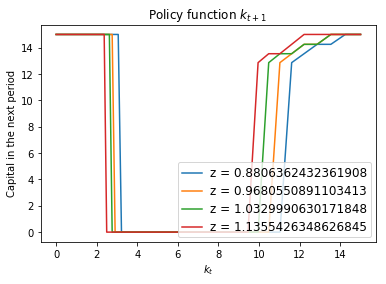

In [130]:
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[1:],  k_grid[PF[1:,0]], label= 'z = ' + str(z_grid[0]))
ax.plot(k_grid[1:],  k_grid[PF[1:,1]], label= 'z = ' + str(z_grid[1]))
ax.plot(k_grid[1:],  k_grid[PF[1:,2]], label= 'z = ' + str(z_grid[2]))
ax.plot(k_grid[1:],  k_grid[PF[1:,3]], label= 'z = ' + str(z_grid[3]))

# Now add the legend with some customizations.
legend = ax.legend(loc='lower right', shadow=False)

# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

plt.xlabel('$k_t$')
plt.ylabel('Capital in the next period')
plt.title('Policy function $k_{t+1}$ ')
plt.show()

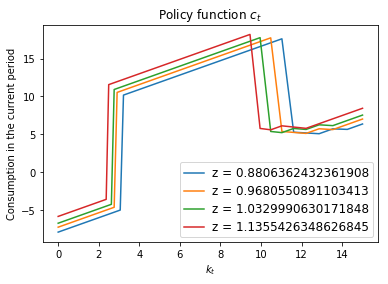

In [131]:
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[1:],  np.exp(z_grid[0])*(k_grid[i]**alpha) - k_grid[PF[1:,0]]+(1-delta)*k_grid[1:], label= 'z = ' + str(z_grid[0]))
ax.plot(k_grid[1:],  np.exp(z_grid[1])*(k_grid[i]**alpha) - k_grid[PF[1:,1]]+(1-delta)*k_grid[1:], label= 'z = ' + str(z_grid[1]))
ax.plot(k_grid[1:],  np.exp(z_grid[2])*(k_grid[i]**alpha) - k_grid[PF[1:,2]]+(1-delta)*k_grid[1:], label= 'z = ' + str(z_grid[2]))
ax.plot(k_grid[1:],  np.exp(z_grid[3])*(k_grid[i]**alpha) - k_grid[PF[1:,3]]+(1-delta)*k_grid[1:], label= 'z = ' + str(z_grid[3]))

# Now add the legend with some customizations.
legend = ax.legend(loc='lower right', shadow=False)

# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

plt.xlabel('$k_t$')
plt.ylabel('Consumption in the current period')
plt.title('Policy function $c_{t}$ ')
plt.show()

## Exercise 4
### 1. Write down the Bellman equation representing this optimal stopping problem.
Answer : 

\begin{align*}
V(w_{t}) = & \max \{\frac{w_{t}}{1-\beta}, b + \beta \int_{0}^{W} V(\tilde{w})f(\tilde{w})d\tilde{w}\}  
 \end{align*}
 
 where $f(.)$ is density of the wage distribution with cdf $F$. Here, I assume $F(b) < 1$ (at least some offers are higher than b) and $F(W) = 1$ for some $W$. 
 
 ### 2.
 
Reservation wage:

$$V(w_{R}) = \frac{w_{R}}{1-\beta} = b + \beta [F(w_{R})V(w_{R}) + \int_{w_{R}}^{W} \frac{\tilde{w}}{1-\beta}f(\tilde{w})d\tilde{w}$$

If we subtract $\frac{\beta}{1-\beta}w_{R}$, we get

$$w_{R} - b = \frac{\beta}{1-\beta} [\int_{w_{R}}^{W} \frac{\tilde{w}}{1-\beta}f(\tilde{w})d\tilde{w}]$$

 
 
 
 
 

In [132]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt

# to print plots inline
%matplotlib inline

# Declare parameters
# Preference parameters
beta = 0.96
lb_b  = 0.05
ub_b = 1.0
size_b = 100
b_grid =  np.linspace(lb_b, ub_b, size_b)


size_w = 10  # number of grid points in epsilon-space
mu_w = 0.0
rho_w = 0.0
sigma_w = 0.15


#Create Grids of Shocks

ln_w_grid, pi_w = addacooper(size_w, mu_w, rho_w, sigma_w)
w_grid = np.exp(ln_w_grid)
pi = np.transpose(pi_w)

In [133]:
#Value Function Iteration
VFtol = 1e-8 
VFdist = 7.0 
VFmaxiter = 3000 
V0 = np.zeros((size_b, size_w)) # initial guess at value function
V  = np.zeros((size_b, size_w)) # initial guess at value function
TV = np.zeros((size_b, size_w))
PF_discrete = np.zeros((size_b, size_w))
VFiter = 1 
while VFdist > VFtol and VFiter < VFmaxiter:
    for i in range(size_b): # loop over b
        for j in range(size_w): # loop over w
            EV = 0
            for jj in range(size_w):  # loop over w'
                EV += pi[j, jj] * V[i,jj]   #  V[i,ii] = V[b,w'] 
            V0[i,j] = b_grid[i] + beta * EV 
            V1      = w_grid[j]/(1-beta)
            TV[i, j] = max(V1, V0[i,j])
            PF_discrete[i, j] = V1 >= V0[i,j]  #  if = 1 take the job!
            
    VFdist = (np.absolute(V - TV)).max()  # check distance
    V = np.copy(TV)
    VFiter += 1 

if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')            


VF = V # solution to the functional equation
print('The distance between V and TV is : ',VFdist)

Value function converged after this many iterations: 124
The distance between V and TV is :  9.70221591956033e-09


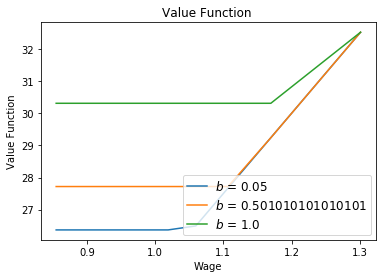

In [134]:
# Thresholds
threshold_w = np.zeros(size_b)
for j in range(size_b):
    threshold_w[j] = w_grid[np.argmax(PF_discrete[j, :])]

# Plot value function 
plt.figure()
fig, ax = plt.subplots()
ax.plot(w_grid[1:], VF[0, 1:], label='$b$ = ' + str(b_grid[0]))
ax.plot(w_grid[1:], VF[47, 1:], label='$b$ = ' + str(b_grid[47]))
ax.plot(w_grid[1:], VF[size_b-1, 1:], label='$b$ = ' + str(b_grid[size_b-1]))
# Now add the legend with some customizations.
legend = ax.legend(loc='lower right', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Wage')
plt.ylabel('Value Function')
plt.title('Value Function ')
plt.show()

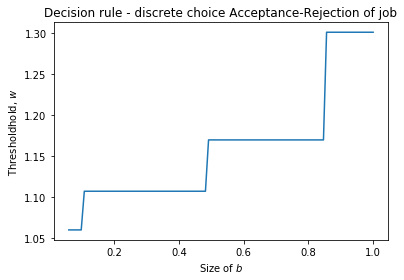

In [135]:
# Plot threshold
plt.figure()
plt.plot(b_grid[1:], threshold_w[1:])
plt.xlabel('Size of $b$')
plt.ylabel('Thresholdhold, $w$')
plt.title('Decision rule - discrete choice Acceptance-Rejection of job')
plt.show()